In [17]:
import pandas as pd
import matplotlib.pyplot as plt


<AxesSubplot:xlabel='time'>

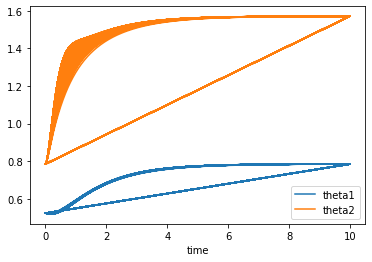

In [29]:
with open('header.txt') as f:
    header = f.readline().split('\t')

df = pd.read_csv('/home/guy/code/2d-robot-prognostics/shoulder10-elbow10.csv', sep=' ', names=header)
df.plot(x='time', y=['theta1','theta2'])
